# Load cleaned data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import training_data_cleaning_joining as clean

In [3]:
sales_clean = clean.clean_sales_data()
items_clean = clean.clean_items_data()
categories_clean = clean.clean_items_categ_data()
shops_clean = clean.clean_shops_data()

In [49]:
test_data = clean.load_test_data()
sample_submission = clean.load_submission_file()

# EDA training data

## Main sales data

In [4]:
sales_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935843 entries, 0 to 2935848
Data columns (total 12 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      int64
year              int64
month             int64
day_of_month      int64
month_year        object
weekday_name      object
day_of_week       int64
dtypes: datetime64[ns](1), float64(1), int64(8), object(2)
memory usage: 291.2+ MB


In [5]:
sales_clean.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day_of_month,month_year,weekday_name,day_of_week
0,2013-01-02,0,59,22154,999.00,1,2013,1,2,2013-01,Wednesday,2
1,2013-01-03,0,25,2552,899.00,1,2013,1,3,2013-01,Thursday,3
2,2013-01-05,0,25,2552,899.00,-1,2013,1,5,2013-01,Saturday,5
3,2013-01-06,0,25,2554,1709.05,1,2013,1,6,2013-01,Sunday,6
4,2013-01-15,0,25,2555,1099.00,1,2013,1,15,2013-01,Tuesday,1


In [6]:
sales_clean['shop_id'].nunique()

60

In [7]:
sales_clean['item_id'].nunique()

21807

In [8]:
sales_clean.isnull().sum() # no NaN values

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
year              0
month             0
day_of_month      0
month_year        0
weekday_name      0
day_of_week       0
dtype: int64

### Individual features in sales data

#### Sale dates

In [9]:
sales_clean['date'].describe()

count                 2935843
unique                   1034
top       2013-12-28 00:00:00
freq                     9434
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: date, dtype: object

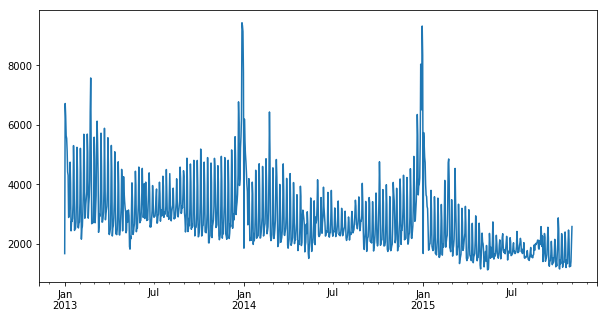

In [10]:
sales_clean['date'].value_counts().sort_index().plot(figsize=(10,5));

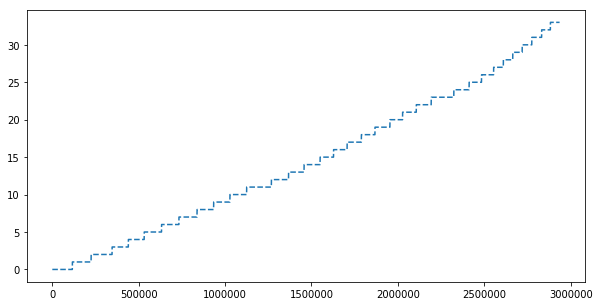

In [11]:
sales_clean['date_block_num'].plot(style='--', figsize=(10,5));

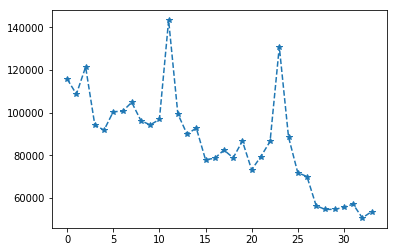

In [12]:
sales_clean['date_block_num'].value_counts().sort_index().plot(style='*--');

#### Shops

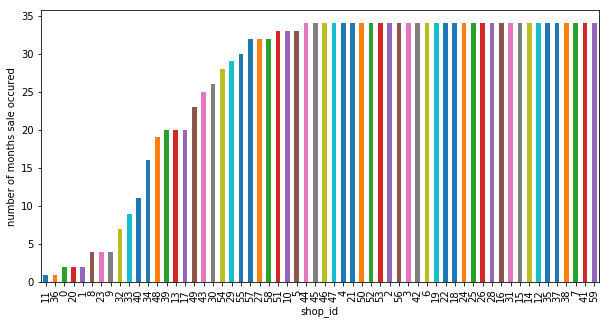

In [13]:
sales_clean.groupby('shop_id')['date_block_num'].nunique().sort_values().plot(kind='bar', figsize=(10,5))
plt.ylabel('number of months sale occured')
plt.show()


In [14]:
sales_clean['item_id'].min(), sales_clean['item_id'].max()

(0, 22169)

#### Items

In [15]:
sales_clean['item_id'].min(), sales_clean['item_id'].max()

(0, 22169)

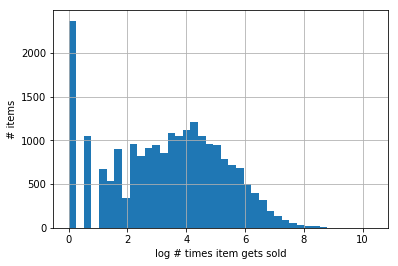

In [16]:
np.log(sales_clean['item_id'].value_counts()).hist(bins=40)
plt.xlabel('log # times item gets sold')
plt.ylabel('# items')
plt.show()

#### Item price

In [17]:
# remove one row with price = -1 (probably missing value imputation)
sales_clean = sales_clean[sales_clean['item_price']>0.0]

In [18]:
sales_clean['item_price'].describe()

count    2.935842e+06
mean     8.908538e+02
std      1.729802e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

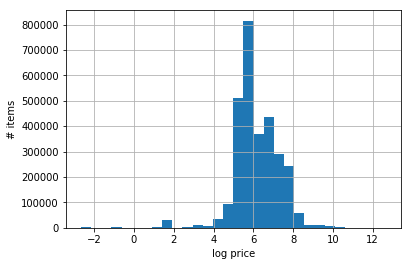

In [19]:
np.log(sales_clean['item_price']).hist(bins=30)
plt.xlabel('log price')
plt.ylabel('# items')
plt.show()

#### Item count per day

In [20]:
sales_clean['item_cnt_day'].describe()

count    2.935842e+06
mean     1.242641e+00
std      2.618838e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [21]:
sales_clean[sales_clean['item_cnt_day']<0]['item_cnt_day'].value_counts()

-1     7252
-2       78
-3       14
-5        4
-4        3
-6        2
-9        1
-22       1
-16       1
Name: item_cnt_day, dtype: int64

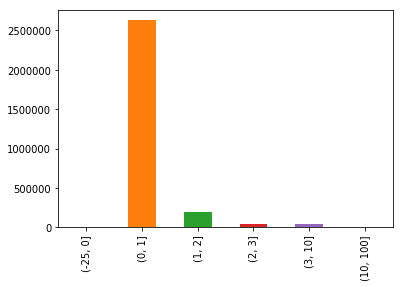

In [22]:
pd.cut(sales_clean['item_cnt_day'], bins=[-25,0,1,2,3,10,100]).value_counts().sort_index().plot(kind='bar');
# usually a row entry is about one item

### Relationship with target

#### Sales over time

In [23]:
sales_clean.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day_of_month,month_year,weekday_name,day_of_week
0,2013-01-02,0,59,22154,999.00,1,2013,1,2,2013-01,Wednesday,2
1,2013-01-03,0,25,2552,899.00,1,2013,1,3,2013-01,Thursday,3
2,2013-01-05,0,25,2552,899.00,-1,2013,1,5,2013-01,Saturday,5
3,2013-01-06,0,25,2554,1709.05,1,2013,1,6,2013-01,Sunday,6
4,2013-01-15,0,25,2555,1099.00,1,2013,1,15,2013-01,Tuesday,1


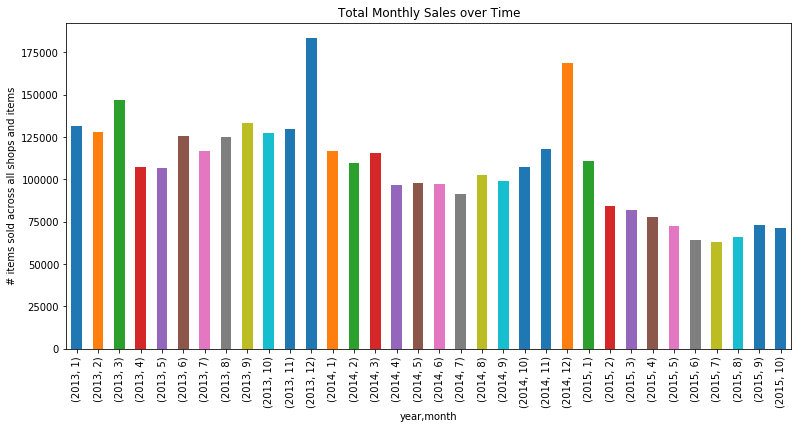

In [24]:
sales_clean.groupby(['year', 'month'])['item_cnt_day'].sum().plot.bar(figsize=(13,6))
plt.ylabel('# items sold across all shops and items')
plt.title('Total Monthly Sales over Time')
plt.show()

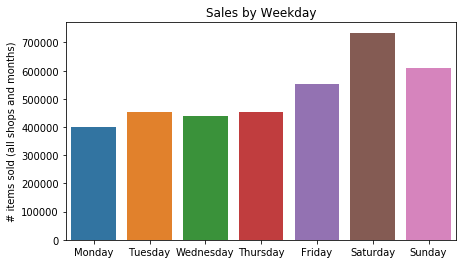

In [25]:
sales_by_weekday = sales_clean.groupby(['weekday_name', 'day_of_week'])['item_cnt_day'].sum().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(x='weekday_name', y='item_cnt_day', data=sales_by_weekday.sort_values(by=['day_of_week']))
plt.xlabel(' ')
plt.ylabel('# items sold (all shops and months)')
plt.title('Sales by Weekday')
plt.show()

#### Shops size by sale

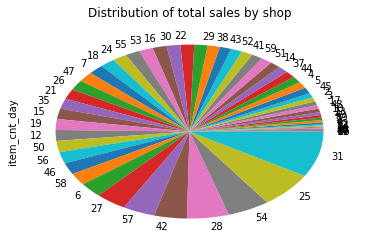

In [26]:
sales_clean.groupby('shop_id')['item_cnt_day'].sum().sort_values().plot(kind='pie')
plt.title('Distribution of total sales by shop')
plt.show()

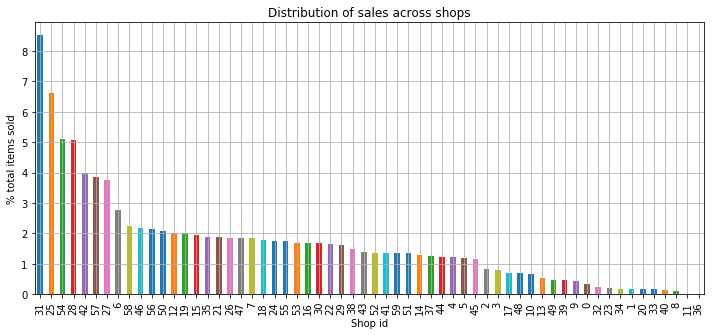

In [27]:
total_items_sold = sales_clean['item_cnt_day'].sum()
pct_items_shop = (100* sales_clean.groupby('shop_id')['item_cnt_day'].sum()/total_items_sold)
pct_items_shop.sort_values(ascending=False).plot(kind='bar', grid=True, figsize=(12,5));
plt.title('Distribution of sales across shops')
plt.ylabel('% total items sold')
plt.xlabel('Shop id')
plt.show()

In [28]:
pct_items_shop.sort_values(ascending=False).head(8).sum()

39.642245392863714

#### Items sold

In [29]:
sales_clean.groupby('item_id')['item_cnt_day'].sum().sort_values().describe()

count     21807.000000
mean        167.294859
std        1366.219932
min         -11.000000
25%           7.000000
50%          33.000000
75%         124.000000
max      187642.000000
Name: item_cnt_day, dtype: float64

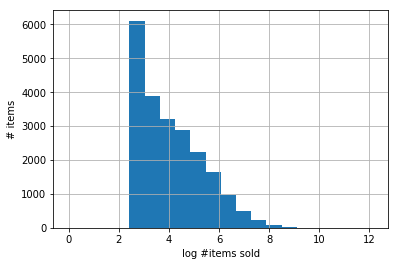

In [30]:
np.log(sales_clean.groupby('item_id')['item_cnt_day'].sum() + 12).hist(bins=20)
plt.xlabel('log #items sold')
plt.ylabel('# items')
plt.show()

#### Item price and sales

In [31]:
item_price_sale = sales_clean.groupby('item_id').agg({'item_price':['mean'], 'item_cnt_day':['sum']})

### Relationship between features

#### Shops over time

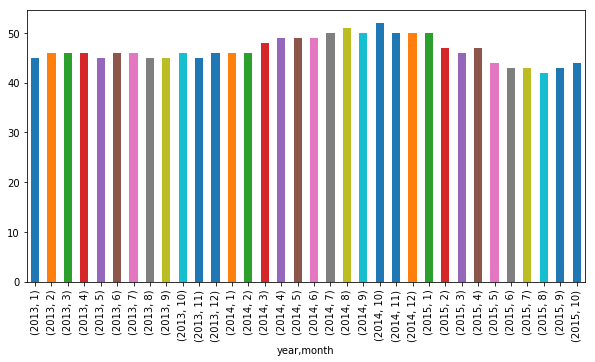

In [32]:
sales_clean.groupby(['year', 'month'])['shop_id'].nunique().plot(kind='bar', figsize=(10,5));

In [33]:
sales_times = sales_clean.groupby('shop_id')['month_year'].agg([np.min, np.max]).reset_index()

In [34]:
sales_times.rename(columns={'amin':'first_sale_month',
                            'amax': 'last_sale_month'}, inplace=True)

In [35]:
sales_times.groupby(['last_sale_month', 'first_sale_month']).count()

shop_id
last_sale_month first_sale_month         
2013-02         2013-01                 2
2013-04         2013-01                 2
2013-07         2013-01                 1
2014-08         2013-01                 1
2015-01         2013-01                 1
                2013-06                 1
                2014-03                 1
2015-02         2013-01                 1
                2015-02                 1
2015-04         2013-01                 1
                2014-08                 1
2015-05         2013-01                 1
2015-09         2013-01                 2
2015-10         2013-01                33
                2013-02                 1
                2013-03                 2
                2013-05                 1
                2013-10                 1
                2013-12                 1
                2014-03                 1
                2014-04                 1
                2014-07                 1
                2014-10                 1
                2015-10                 1

In [36]:
sales_clean.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day_of_month,month_year,weekday_name,day_of_week
0,2013-01-02,0,59,22154,999.00,1,2013,1,2,2013-01,Wednesday,2
1,2013-01-03,0,25,2552,899.00,1,2013,1,3,2013-01,Thursday,3
2,2013-01-05,0,25,2552,899.00,-1,2013,1,5,2013-01,Saturday,5
3,2013-01-06,0,25,2554,1709.05,1,2013,1,6,2013-01,Sunday,6
4,2013-01-15,0,25,2555,1099.00,1,2013,1,15,2013-01,Tuesday,1


#### How many items shops sell

In [37]:
total_unique_items = sales_clean['item_id'].nunique()
pct_unique_items = (100 * sales_clean.groupby('shop_id')['item_id'].nunique()/total_unique_items)

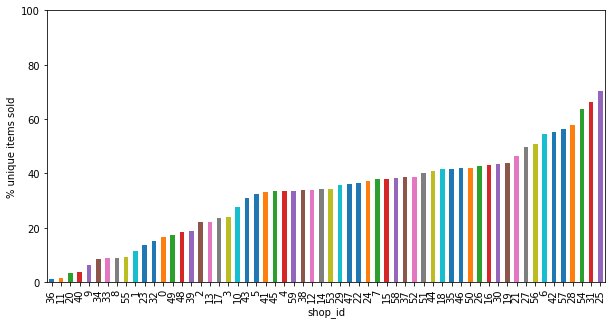

In [38]:
pct_unique_items.sort_values().plot(kind='bar', figsize=(10,5), ylim=(0,100))
plt.ylabel('% unique items sold')
plt.show()

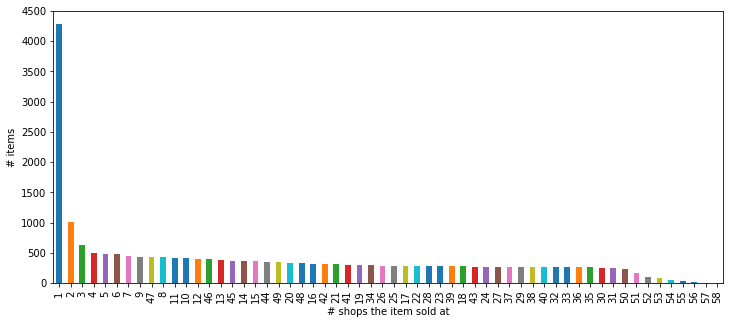

In [39]:
item_shops = sales_clean.groupby('item_id')['shop_id'].nunique()  # in how many shops are items sold
item_shops.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(12,5))
plt.ylabel('# items')
plt.xlabel('# shops the item sold at')
plt.show()

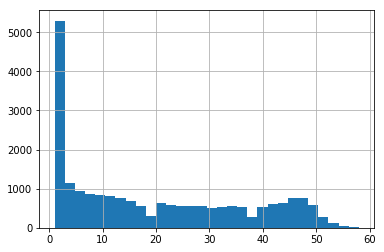

In [40]:
sales_clean.groupby('item_id')['shop_id'].nunique().hist(bins=30);

In [41]:
sales_clean.groupby('item_id')['item_cnt_day'].sum().describe()

count     21807.000000
mean        167.294859
std        1366.219932
min         -11.000000
25%           7.000000
50%          33.000000
75%         124.000000
max      187642.000000
Name: item_cnt_day, dtype: float64

## EDA item background data

In [42]:
items_clean.head()

,item_name,item_id,item_category_id,item_name_proc
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,ABBYY FineReader 12 Professional Edition Full ...
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,В ЛУЧАХ СЛАВЫ (UNV) D
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,ГОЛУБАЯ ВОЛНА (Univ) D
4,***КОРОБКА (СТЕКЛО) D,4,40,КОРОБКА (СТЕКЛО) D


In [43]:
items_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 4 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
item_name_proc      22170 non-null object
dtypes: int64(2), object(2)
memory usage: 692.9+ KB


In [44]:
items_clean['item_category_id'].nunique()

84

In [45]:
categories_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 4 columns):
item_category_name        84 non-null object
item_category_id          84 non-null int64
item_category_name_eng    84 non-null object
item_category_group       84 non-null category
dtypes: category(1), int64(1), object(2)
memory usage: 2.9+ KB


In [46]:
categories_clean.sample(5)

,item_category_name,item_category_id,item_category_name_eng,item_category_group
75,Программы - Для дома и офиса,75,Programs - Home and Office,Programs
32,"Карты оплаты (Кино, Музыка, Игры)",32,"Payment cards (Movies, Music, Games)","Payment cards (Movies, Music, Games)"
18,Игры - PS2,18,Games - PS2,Games
54,Книги - Цифра,54,Books - Number,Books
0,PC - Гарнитуры/Наушники,0,PC - Headsets / Headphones,PC


## EDA shops data

In [47]:
shops_clean.head()

,shop_name,shop_id,shop_name_eng,shop_city
0,"!Якутск Орджоникидзе, 56 фран",0,"yakutsk ordzhonikidze, 56 francs",yakutsk
1,"!Якутск ТЦ ""Центральный"" фран",1,"yakutsk tc ""central"" franc",yakutsk
2,"Адыгея ТЦ ""Мега""",2,"adygea shopping center ""mega""",adygea
3,"Балашиха ТРК ""Октябрь-Киномир""",3,"balashikha trk ""october-kinomir""",balashikha
4,"Волжский ТЦ ""Волга Молл""",4,"volzhsky shopping center ""volga mall""",volzhsky


In [48]:
shops_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
shop_name        60 non-null object
shop_id          60 non-null int64
shop_name_eng    60 non-null object
shop_city        60 non-null category
dtypes: category(1), int64(1), object(2)
memory usage: 3.0+ KB


# EDA test data

In [50]:
test_data['shop_id'].nunique()

42

In [51]:
test_data['item_id'].nunique()

5100

# Submission data

In [53]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
